# Scaling noiso on IBMQ devices

In [1]:
from qiskit import IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise.noise_model import NoiseModel
from qiskit.providers.aer.noise import ReadoutError
import numpy as np
from utilities import scale_noise, vd

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
IBMQ.load_account()
# Device to be simulated
dev = IBMQ.get_provider().get_backend("ibmq_manila")

# Extracted simulator for the device
sim = AerSimulator.from_backend(dev)

# noise model of the simulator
noise_model = NoiseModel().from_backend(dev)

ibmqfactory.load_account:WARNING:2022-04-22 06:22:05,249: Credentials are already in use. The existing account in the session will be replaced.


## Scaling the noise

In [4]:
# ## Scales the noise model.
# ##  - qscale is the common scale parameter for the quantum errors
# ##  - roscale is the common parameter for the readout errrors; if not
# ##    provided, the value of qscale is used
# ## The scale parameters should be from interval [0, 1]
# ## with 0 for ideal device and 1 for simulated device
# def scale_noise(noise_model, qscale, roscale=None):
#     if roscale is None:
#         roscale = qscale
#
#     ## Scaled version of the noise_model
#     scaled = NoiseModel(basis_gates=noise_model.basis_gates)
#
#     ## Quantum errors are stored in _local_quantum_errors attribute
#     ## dictionary; _local_quantum_errors[operation][qubits] stores
#     ## the Qiskit QuantumError in which probabilities are stored
#     ## in _probs attribute
#     qerrors = noise_model._local_quantum_errors
#     for op in qerrors:
#         for qubits in qerrors[op]:
#             ## Copy the error
#             newerror = qerrors[op][qubits].copy()
#
#             ## Scale the probabilities
#             probs = qscale * np.array(newerror.probabilities)
#             probs[0] += 1 - qscale
#             newerror._probs = probs
#
#             ## Add error to the scaled noise model
#             scaled.add_quantum_error(newerror, op, qubits)
#
#     ## Readout errors are stored in _local_readout_errors attribute
#     ## dictionary; _local_readout_errors[qubits] stores the Qiskit
#     ## ReadoutError; we could change the probabilities as in the previous
#     ## case, but here it is simpler to construct completely
#     ## new ReadoutError
#     roerrors = noise_model._local_readout_errors
#     for qubits in roerrors:
#         ## Reading probabilities
#         probs = roerrors[qubits].probabilities
#
#         ## Scale the probabilites
#         error0 = roscale * probs[0][1]
#         error1 = roscale * probs[1][0]
#
#         ## Construction and addition of the error to the scaled noise model
#         newerror = ReadoutError(np.array([[1 - error0, error0], [error1, 1 - error1]]))
#         scaled.add_readout_error(newerror, qubits)
#
#     return scaled

In [5]:
scale_noise(noise_model, 1) == noise_model

True

In [6]:
scale_noise(noise_model, 0.5, 0.8) == noise_model

False

## Test

In [7]:
import qiskit
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [8]:
SHOTS = 10000
n_qubits = 4
OUTCOMES = [f"{j:04b}" for j in range(16)]

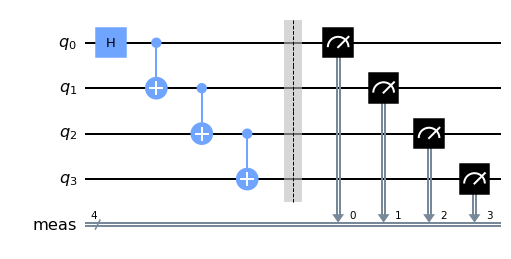

In [9]:
# System Specification
circ = qiskit.QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
circ.draw(output="mpl")

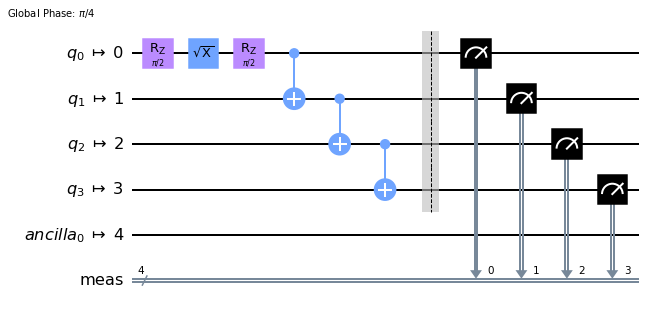

In [10]:
circ = qiskit.transpile(circ, dev)
circ.draw(output="mpl")

In [11]:
def simulate(circ, qscale, roscale=None):
    # Create noisy simulator backend
    noise_model = scale_noise(NoiseModel().from_backend(dev), qscale, roscale)
    sim_noise = AerSimulator(noise_model=noise_model)

    # Run and get counts
    result = sim_noise.run(circ, shots=SHOTS).result()

    return result.get_counts()

In [12]:
scales = np.linspace(0, 1, 15)
both = [simulate(circ, qscale) for qscale in scales]
qerrors = [simulate(circ, qscale, roscale=0.) for qscale in scales]
roerrors = [simulate(circ, 0., roscale) for roscale in scales]

In [ ]:
job = qiskit.execute(circ, dev, shots=SHOTS)
real = job.result().get_counts()

In [ ]:
d_both = [vd(dist, both[0]) for dist in both]
d_qerrors = [vd(dist, qerrors[0]) for dist in qerrors]
d_roerrors = [vd(dist, roerrors[0]) for dist in roerrors]

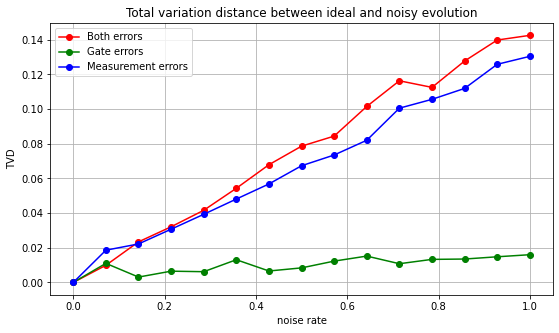

In [16]:
## Figure initialization
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.grid(True)
ax.set_title("Total variation distance between ideal and noisy evolution")
ax.set_ylabel("TVD")
ax.set_xlabel("noise rate")

ax.plot(scales, d_both, "-or", label="Both errors")
ax.plot(scales, d_qerrors, "-og", label="Gate errors")
ax.plot(scales, d_roerrors, "-ob", label="Measurement errors")
ax.legend()

plt.show()

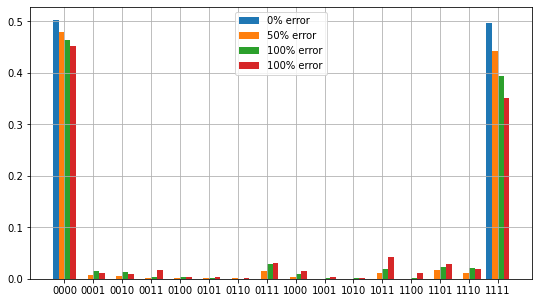

In [17]:
## Figure initialization
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.grid(True)

xrange = np.linspace(0, 15, 16)
# ax.set_title("Time evolution of measuring 0s and 1s success rates.")
# ax.set_ylabel("Success probability")

width = 0.8 / 4

ax.bar(xrange - 3 * width / 2., [both[0].get(x, 0) / SHOTS for x in OUTCOMES], width=width, label="0% error")
ax.bar(xrange - width / 2., [both[7].get(x, 0) / SHOTS for x in OUTCOMES], width=width, label="50% error")
ax.bar(xrange + width / 2., [both[14].get(x, 0) / SHOTS for x in OUTCOMES], width=width, label="100% error")
ax.bar(xrange + 3 * width / 2., [real.get(x, 0) / SHOTS for x in OUTCOMES], width=width, label="100% error")

plt.xticks(xrange, OUTCOMES)
ax.legend()

plt.show()